Now try the new data with over sampling

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix , roc_auc_score, roc_curve, precision_recall_curve, auc
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os
from keras.utils import to_categorical
tf.test.is_gpu_available()
os.chdir('/data/swamyvs/pacbio_testing/')

/data/swamyvs/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [3]:


def random_over_sampler(X, Y,class_to_oversample, random_state):
    ''' X is a ndarray, y is a data frame'''

    indexs=np.array(range(len(X)))
    minority_index_bool= Y['target_label'] == class_to_oversample
    minority_index=indexs[minority_index_bool]
    majority_index=indexs[~minority_index_bool]
    output_size=sum(~minority_index_bool)
    np.random.seed(seed=random_state)
    resample_index=np.concatenate([np.random.choice(minority_index, size=output_size, replace=True ) , majority_index])
    X_resampled=X[resample_index]
    Y_resampled=Y.iloc[resample_index].reset_index(drop=True)
    return X_resampled, Y_resampled

class SimpleDataObj_RS:
    def __init__(self, x_mat_file, labels_file,kmer_size, one_label, zero_label, y_format='tf'):
        positive_cases=['all', 'stringtie-pacbio', 'scallop-pacbio']
        X_df=pd.read_csv(x_mat_file,names=['transcript_id']+ list(range(kmer_size)))
        labs=(pd
            .read_csv(labels_file, sep= '\t', names=['transcript_id', 'intersection_case'])
            .assign(target_label=lambda x: np.where(x['intersection_case'].isin(positive_cases),1,0 )) )
        X_df_labeled=pd.merge(left=labs, right=X_df, left_on='transcript_id', right_on='transcript_id')
        X_data=np.asarray(X_df_labeled.iloc[:,3:])#drop the first 3 columns
        Y_vec=np.asarray(X_df_labeled['target_label'])
        
    
        self.Y_origin=X_df_labeled.iloc[:,:3]
        self.vec_y=Y_vec
        
        X_train, self.X_test, Y_train_labs, Y_test_labs= train_test_split(X_data,labs,test_size=.16, random_state=42, stratify=Y_vec)
        X_train, Y_train_labs  = random_over_sampler(X_train, Y_train_labs, 1, 34)
        self.X_train, self.X_val, Y_train_labs, Y_val_labs=train_test_split(X_train,Y_train_labs,test_size=.23809, 
                                                                                  random_state=42,stratify=Y_train_labs['target_label'])

        if y_format == 'tf':
            self.Y_val=to_categorical(Y_val_labs['target_label'])
            self.Y_train=to_categorical(Y_train_labs['target_label'])
            self.Y_test=to_categorical(Y_test_labs['target_label'])
        else:
            self.Y_val=np.asarray(Y_val_labs['target_label'])
            self.Y_train=np.asarray(Y_train_labs['target_label'])
            self.Y_test=np.asarray(Y_test_labs['target_label'])
            
        self.Y_val_labs=Y_val_labs[['transcript_id','intersection_case']] 
        self.Y_train_labs=Y_train_labs[['transcript_id','intersection_case']]
        self.Y_test_labs=Y_test_labs[['transcript_id','intersection_case']]
            
        self.y_format=y_format
        self.one_label=one_label
        self.zero_label=zero_label
    def summary(self):
        tr_len=len(self.X_train)
        ts_len=len(self.X_test)
        v_len= len(self.X_val)
        print(f'Training size: {tr_len}\nvalidation size: {v_len}\ntesting size: {ts_len}')
        print(f'{self.one_label} count: {np.count_nonzero(self.vec_y == 1)}\n{self.zero_label} count : {np.count_nonzero(self.vec_y == 0)}')


def ROC_plot(Y_test, Y_prob):
    fpr, tpr, thresholds=roc_curve(Y_test, Y_prob)
    auc=roc_auc_score(Y_test, Y_prob)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
def PR_plot(Y_test, Y_prob):
    pre, rec, thresholds = precision_recall_curve(Y_test, Y_prob)
    AUC = auc(rec, pre)
    plt.plot(rec, pre, label=' Prec/Rec (area = %0.2f)' % ( AUC))
    plt.plot([1, 1], [1, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('')
    plt.legend(loc="lower right")
    plt.show()  
def skl_model_results(obj, model):
    X_train=obj.X_train
    Y_train=obj.Y_train
    X_test=obj.X_test
    Y_test=obj.Y_test
    Y_pred=model.predict(X_test)
    Y_prob=model.predict_proba(X_test)[:,1]
    labs=model.classes_
    print('confusion matrix\n\n')
    print(pd.DataFrame(confusion_matrix(Y_test, Y_pred), index=labs, columns=labs))
    print('\n\nclassification report\n\n')
    print(classification_report(y_pred=Y_pred,y_true=Y_test))
    ROC_plot(Y_test , Y_prob)
    PR_plot(Y_test,Y_prob)
    return(model)


In [4]:
dat=SimpleDataObj_RS('data/embedded_model_data/all_RPE_loose_kmers_12_dims-300.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                   300,
                  'transcript',
                  'not_transcript',
                  'sk'
                 )

In [5]:
dat.summary()

Training size: 515566
validation size: 161110
testing size: 96170
transcript count: 198277
not_transcript count : 402784


In [10]:
rf_model=RandomForestClassifier(n_estimators=100, random_state=32, n_jobs=32)
rf_model.fit(dat.X_train, dat.Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=32, oob_score=False, random_state=32, verbose=0,
                       warm_start=False)

confusion matrix


       0      1
0  55278   9168
1  17342  14382


classification report


              precision    recall  f1-score   support

           0       0.76      0.86      0.81     64446
           1       0.61      0.45      0.52     31724

    accuracy                           0.72     96170
   macro avg       0.69      0.66      0.66     96170
weighted avg       0.71      0.72      0.71     96170



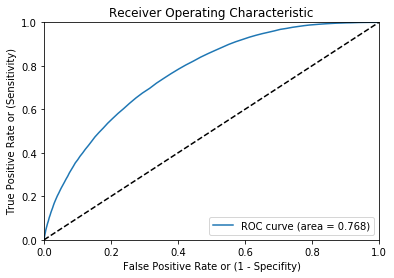

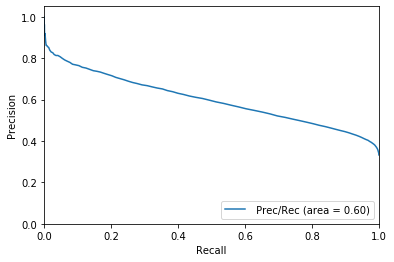

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=32, oob_score=False, random_state=32, verbose=0,
                       warm_start=False)

In [13]:
skl_model_results(dat, rf_model)

In [8]:
MAX_TRAIN_SIZE=len(dat_tf.X_train) +1
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


def train_dense_model(obj):
    model=keras.Sequential()
    model.add(keras.layers.Dense(300,activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    
    model.add(keras.layers.Dense(200,activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    
    model.add(keras.layers.Dense(100,  activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    
    model.add(keras.layers.Dense(10,activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    
    model.add(keras.layers.Dense(2, activation='softmax'))
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
    history=model.fit(obj.X_train, obj.Y_train, epochs=200, batch_size= MAX_TRAIN_SIZE, 
                    validation_data=(obj.X_val, obj.Y_val), verbose=0)
    #model.predict()
    return(history, model)
def run_all(model, data, plot_title):
    history, model = model(data)
    metrics =  ['loss', 'auc', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,3,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.7,1])
        else:
            plt.ylim([0,1])

        plt.legend()
    pred=[p[1] for p in  model.predict(data.X_test)]
    pred_class = np.int64([p > .5 for p in pred])
    true_class=[i[1] for i in data.Y_test]
    
    fpr, tpr, thresholds=roc_curve(true_class, pred)
    AUC=roc_auc_score(true_class, pred)
    # Plot ROC curve
    plt.subplot(2,3,4)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % AUC)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
   
    pre, rec, thresholds = precision_recall_curve(true_class, pred)
    AUC = auc(rec, pre)
    plt.subplot(2,3,5)
    plt.plot(rec, pre, label=' Prec/Rec (area = %0.2f)' % ( AUC))
    plt.plot([1, 1], [1, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall plot')
    plt.legend(loc="lower right")
    
    
    plt.suptitle(plot_title)
    plt.show()
    labs=[data.zero_label, data.one_label] 
    print(pd.DataFrame(confusion_matrix(true_class, pred_class), index=labs, columns=labs))
    print(classification_report(pred_class,true_class))
    return history, model 


In [7]:
dat_tf=SimpleDataObj_RS('data/embedded_model_data/all_RPE_loose_kmers_12_dims-300.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                   300,
                  'transcript',
                  'not_transcript',
                  'tf'
                 )

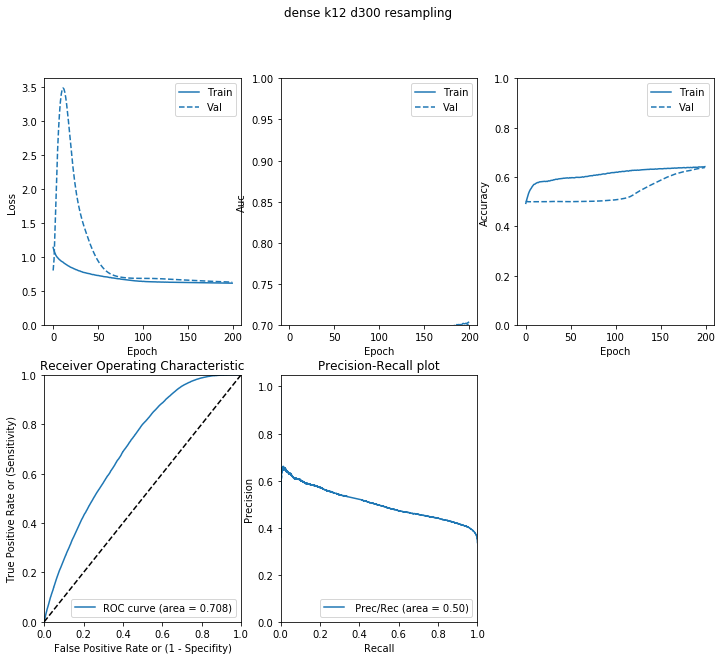

                not_transcript  transcript
not_transcript           22294       42152
transcript                2360       29364
              precision    recall  f1-score   support

           0       0.35      0.90      0.50     24654
           1       0.93      0.41      0.57     71516

    accuracy                           0.54     96170
   macro avg       0.64      0.66      0.53     96170
weighted avg       0.78      0.54      0.55     96170



In [9]:
dense_hist, dense_model=run_all(train_dense_model, dat_tf, 'dense k12 d300 resampling')

In [16]:
class RnnDataObj_RS:
    def __init__(self, x_mat_file, labels_file,kmer_size,block_size, one_label, zero_label):
        positive_cases=['all', 'stringtie-pacbio', 'scallop-pacbio']
        X_df=pd.read_csv(x_mat_file,names=['transcript_id']+ list(range(kmer_size)))
        labs=(pd
            .read_csv(labels_file, sep= '\t', names=['transcript_id', 'intersection_case'] )
            .assign(target_label=lambda x: np.where(x['intersection_case'].isin(positive_cases),1,0 )) )
        X_df_labeled=pd.merge(left=labs, right=X_df, left_on='transcript_id', right_on='transcript_id')
        X_data=np.asarray(X_df_labeled.iloc[:,3:])#drop the first 3 columns
        
        assert X_data.shape[1] % block_size == 0
        block_dim=int(X_data.shape[1] / block_size)
        X_data=np.asarray( [vec.reshape(block_size, block_dim) for vec in X_data])
        Y_vec=np.asarray(X_df_labeled['target_label'])
        self.Y_origin=X_df_labeled.iloc[:,:3]
        self.vec_y=Y_vec
        
        X_train, self.X_test, Y_train_labs, Y_test_labs= train_test_split(X_data,labs,test_size=.16, random_state=42, stratify=Y_vec)
        X_train, Y_train_labs  = random_over_sampler(X_train, Y_train_labs, 1, 34)
        self.X_train, self.X_val, Y_train_labs, Y_val_labs=train_test_split(X_train,Y_train_labs,test_size=.23809, 
                                                                                  random_state=42,stratify=Y_train_labs['target_label'])

        self.Y_val=to_categorical(Y_val_labs['target_label'])
        self.Y_train=to_categorical(Y_train_labs['target_label'])
        self.Y_test=to_categorical(Y_test_labs['target_label'])     
        self.Y_val_labs=Y_val_labs[['transcript_id','intersection_case']] 
        self.Y_train_labs=Y_train_labs[['transcript_id','intersection_case']]
        self.Y_test_labs=Y_test_labs[['transcript_id','intersection_case']]
        self.one_label=one_label
        self.zero_label=zero_label
    def summary(self):
        tr_len=len(self.X_train)
        ts_len=len(self.X_test)
        v_len= len(self.X_val)
        print(f'Training size: {tr_len}\nvalidation size: {v_len}\ntesting size: {ts_len}')
        print(f'{self.one_label} count: {np.count_nonzero(self.vec_y == 1)}\n{self.zero_label} count : {np.count_nonzero(self.vec_y == 0)}')
        
        
        
        
def LSTM_dense_model(obj, batch_n=128, nepochs=300):
    NUM_UNITS=150
    MAX_TRAIN_SIZE=int(obj.X_train.shape[0] / batch_n)
    DIM=obj.X_train.shape[1:]
    model=keras.Sequential()
    model.add(keras.layers.Input(shape=DIM))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=NUM_UNITS)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(300,activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    model.add(keras.layers.Dense(100,  activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    model.add(keras.layers.Dense(2, activation='softmax'))
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
    history=model.fit(obj.X_train, obj.Y_train, epochs=nepochs, batch_size= MAX_TRAIN_SIZE, 
                    validation_data=(obj.X_val, obj.Y_val), verbose=0)
    #model.predict()
    return(history, model)

In [17]:
rnn_dat=RnnDataObj_RS('data/embedded_model_data/all_RPE_loose_kmers_12_dims-300.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                   300,
                    30,
                  'transcript',
                  'not_transcript'
                 )


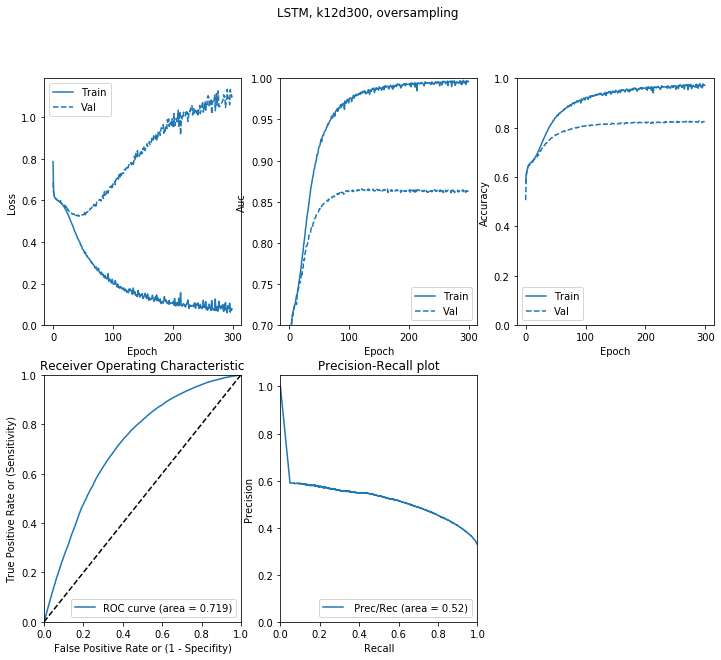

                not_transcript  transcript
not_transcript           48620       15826
transcript               14299       17425
              precision    recall  f1-score   support

           0       0.75      0.77      0.76     62919
           1       0.55      0.52      0.54     33251

    accuracy                           0.69     96170
   macro avg       0.65      0.65      0.65     96170
weighted avg       0.68      0.69      0.68     96170

Training size: 515566
validation size: 161110
testing size: 96170
transcript count: 198277
not_transcript count : 402784


In [19]:
rnn_his, rnn_model = run_all(LSTM_dense_model, rnn_dat, 'LSTM, k12d300, oversampling')
rnn_dat.summary()